In [138]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

In [139]:
captions=pd.read_csv('captions.csv')

In [140]:
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [141]:
captions['caption'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 40455 entries, 0 to 40454
Series name: caption
Non-Null Count  Dtype 
--------------  ----- 
40455 non-null  object
dtypes: object(1)
memory usage: 316.2+ KB


In [142]:
captions['caption'].describe()

count                              40455
unique                             40201
top       Two dogs playing in the snow .
freq                                   7
Name: caption, dtype: object

In [143]:
sequences=captions['caption'].tolist()

In [144]:
sequences[:5]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [145]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(sequences)

In [146]:
tokenizer.word_index.items()

dict_items([('a', 1), ('in', 2), ('the', 3), ('on', 4), ('is', 5), ('and', 6), ('dog', 7), ('with', 8), ('man', 9), ('of', 10), ('two', 11), ('white', 12), ('black', 13), ('boy', 14), ('are', 15), ('woman', 16), ('girl', 17), ('to', 18), ('wearing', 19), ('at', 20), ('people', 21), ('water', 22), ('red', 23), ('young', 24), ('brown', 25), ('an', 26), ('his', 27), ('blue', 28), ('dogs', 29), ('running', 30), ('through', 31), ('playing', 32), ('while', 33), ('shirt', 34), ('down', 35), ('standing', 36), ('ball', 37), ('little', 38), ('grass', 39), ('snow', 40), ('child', 41), ('person', 42), ('jumping', 43), ('over', 44), ('three', 45), ('front', 46), ('sitting', 47), ('holding', 48), ('up', 49), ('field', 50), ('small', 51), ('by', 52), ('large', 53), ('green', 54), ('one', 55), ('group', 56), ('yellow', 57), ('her', 58), ('walking', 59), ('children', 60), ('men', 61), ('into', 62), ('air', 63), ('beach', 64), ('near', 65), ('mouth', 66), ('jumps', 67), ('another', 68), ('for', 69), ('s

In [147]:
max_length=max(len(s.split()) for s in sequences)

In [148]:
max_length

38

In [149]:
def tokenize(sequence):
    sequence=tokenizer.texts_to_sequences(sequence)[0]

    input_sequence=[]
    for j in range(1,len(sequence)):
        n_gram_sequence=sequence[:j+1]
        input_sequence.append(n_gram_sequence)

    input_sequences=np.array(pad_sequences(input_sequence,maxlen=38,padding='pre'))

    xs = input_sequences[:,:-1]
    labels = input_sequences[:,-1]

    return xs,labels


In [150]:
def getdata(data):
    xs,labels=tokenize(data)
    xs=np.array(xs)
    labels=np.array(labels)
    img=captions[captions['caption']==data[0]]['image']
    img=cv2.imread('Images/'+img.iloc[0])
    img=cv2.resize(img,(224,224))
    img=img/255.0
    images=[img]*len(xs)
    return xs,labels,images

In [151]:
def create_dataset():
    xs=[]
    labels=[]
    images=[]
    for i in sequences[:100]:
        x,label,image=getdata([i])
        xs.extend(x)
        labels.extend(label)
        images.extend(image)

    xs=np.array(xs)
    labels=np.array(labels)
    images=np.array(images)

    labels = tf.keras.utils.to_categorical(labels, num_classes=8493)
    
        
    return xs,images,labels

In [152]:
X1,X2,Y=create_dataset()

In [153]:
X1.shape,X2.shape,Y.shape

((1068, 37), (1068, 224, 224, 3), (1068, 8493))

In [154]:
Y=tf.expand_dims(Y,axis=1)

In [155]:
Y.shape

TensorShape([1068, 1, 8493])

In [156]:
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,Conv2D,MaxPooling2D,Flatten,Dropout,concatenate,add,Reshape

In [157]:
max_length=37

In [158]:
input1 = Input(shape=(224,224,3))
input2 = Input(shape=(max_length,))

x1 = Conv2D(128,(3,3),activation='relu',padding='same')(input1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Conv2D(64,(3,3),activation='relu',padding='same')(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Conv2D(32,(3,3),activation='relu',padding='same')(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Flatten()(x1)

x1= Dense(256,activation='relu')(x1)
x1= Dropout(0.5)(x1)
x1= Dense(256,activation='relu')(x1)
x1=Reshape((1,256))(x1)

x2 = Embedding(8493,256,mask_zero=True)(input2)
x2 = LSTM(256)(x2)
x2 = Dense(256,activation='relu')(x2)
x2 = Reshape((1,256))(x2)

merge = concatenate([x1,x2],axis=1)
x3 = LSTM(256)(merge)
x= Dense(256,activation='relu')(x3)
x=add([x,x1])
x=Dropout(0.5)(x)

output = Dense(8493,activation='softmax')(x)


2023-09-03 22:00:22.788752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-03 22:00:22.790853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-03 22:00:22.792141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [159]:
model=tf.keras.Model(inputs=[input2,input1],outputs=output)

In [160]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 224, 224, 12  3584        ['input_11[0][0]']               
                                8)                                                                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 112, 112, 12  0          ['conv2d_13[0][0]']              
 )                              8)                                                          

In [161]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [162]:
type(X1)

numpy.ndarray

In [163]:
type(X2)

numpy.ndarray

In [164]:
type(Y)

tensorflow.python.framework.ops.EagerTensor

In [165]:
X1.shape,X2.shape,Y.shape

((1068, 37), (1068, 224, 224, 3), TensorShape([1068, 1, 8493]))

In [170]:
history=model.fit([X1,X2],Y,epochs=20,batch_size=16)

Epoch 1/20
67/67 [==============================] - 15s 219ms/step - loss: 0.3440 - accuracy: 0.8830
Epoch 2/20
67/67 [==============================] - 14s 212ms/step - loss: 0.3103 - accuracy: 0.8951
Epoch 3/20
67/67 [==============================] - 14s 214ms/step - loss: 0.3221 - accuracy: 0.8914
Epoch 4/20
67/67 [==============================] - 14s 212ms/step - loss: 0.3040 - accuracy: 0.8839
Epoch 5/20
67/67 [==============================] - 14s 204ms/step - loss: 0.2894 - accuracy: 0.9026
Epoch 6/20
67/67 [==============================] - 13s 199ms/step - loss: 0.3183 - accuracy: 0.8848
Epoch 7/20
67/67 [==============================] - 13s 200ms/step - loss: 0.2949 - accuracy: 0.8942
Epoch 8/20
67/67 [==============================] - 14s 206ms/step - loss: 0.3019 - accuracy: 0.8951
Epoch 9/20
67/67 [==============================] - 13s 198ms/step - loss: 0.2774 - accuracy: 0.9026
Epoch 10/20
67/67 [==============================] - 14s 210ms/step - loss: 0.2513 - accura

In [176]:
def predict(image,tokenizer,model):
    img=cv2.imread(image)
    plt.imshow(img)
    img=cv2.resize(img,(224,224))
    img=img/255.0
    img=np.array([img])
    img.shape
    in_text='startseq'
    for i in range(38):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],maxlen=37,padding='pre')
        sequence=np.array(sequence)
        y=model.predict([sequence,img])
        y=np.argmax(y)
        word=''
        for word,index in tokenizer.word_index.items():
            if index==y:
                word=word
                break
        in_text+=' '+word
        if word=='endseq':
            break
    return in_text

1/1 [==============================] - 0s 38ms/step


'startseq grips onto the red ropes over a playground park log with red stroller climbing the duck in the water playing on a fallen tree climbing a pond with a duck wall of a city toy wall with a'

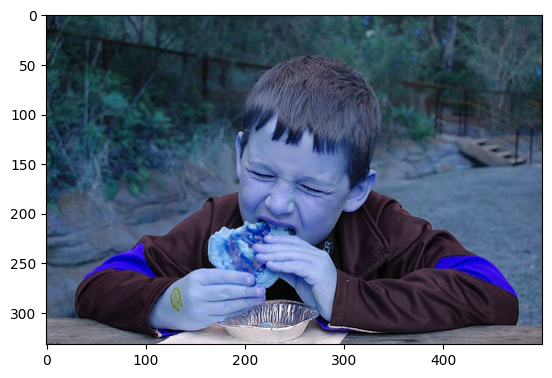

In [179]:
predict('./Images/1034276567_49bb87c51c.jpg',tokenizer,model)

In [180]:
model.save('model.h5')